# AdaBoost Regressor — Reference Implementation for Model Repository

## Overview
This notebook provides the **official reference implementation** of the **AdaBoostRegressor** model for the course-wide machine learning model repository.  
Each student in the course contributes one model to this shared collection, following a consistent structure and documentation standard.  
This ensures that every model—regression or classification—can be reused, compared, or extended in future projects with minimal setup.

The implementation focuses on clarity, reproducibility, and practical usability.  
It includes data loading, model training, basic evaluation, explainability components, and artifact export (pipeline and schema) in a single, well-documented workflow.

## Purpose
The purpose of this notebook is to:
- Provide a **clean, minimal AdaBoostRegressor pipeline** using decision tree base learners.  
- Serve as a **reusable code template** for applying AdaBoost to different datasets.  
- Demonstrate **standard evaluation and diagnostic practices** to ensure consistency and comparability across all model implementations.
- Save model artifacts (`.joblib` and `schema.json`) for seamless reuse in other notebooks or applications.

## What is AdaBoost?
AdaBoost, short for *Adaptive Boosting*, is an ensemble learning method that combines many weak learners (typically shallow decision trees) to form a strong predictor.  
Each subsequent learner focuses on correcting the mistakes of the previous ones, leading to improved accuracy and robustness.  
It is particularly effective for tabular data with non-linear relationships and moderate noise levels.

## How to Use This Model
1. Run all cells sequentially to train and evaluate the AdaBoost Regressor.
2. **To use your own dataset**, replace the `load_data_with_fallback()` function call in Step 2 with your own data loading logic:  
   ```python
   df = pd.read_csv("your_dataset.csv")
   X = df.drop(columns=["target_column"])
   y = df["target_column"]
   columns = X.columns.tolist()
   target_name = "target_column"
   data_source = "custom_dataset"
3. Trained pipeline and schema and other artifacts will be saved to the `artifacts` directory. (Set `path` in step 1)
4. Use the saved `.joblib` file for inference in any compatible environment.

## Outputs
This notebook produces the following artifacts for inclusion in the shared repository:

| Artifact | Description |
|-----------|--------------|
| `metrics.csv` | Performance metrics (RMSE, MAE, R²) for the trained model |
| `learning_curve.png` | RMSE progression across boosting iterations |
| `residuals_vs_pred.png`, `residuals_qq.png` | Visual diagnostics of model residuals |
| `feature_importance.csv` | Feature importance scores (permutation-based) |
| `pdp_<feature>.png` | Partial dependence plots for top features |
| `adaboost_pipeline.joblib` | Serialized AdaBoost pipeline for reuse |
| `schema.json` | Column order, target variable, and data source information |

## Notebook Structure
1. **Imports and Configuration** – setup, helper functions, and reproducibility settings  
2. **Data Loading** – load California Housing dataset (with offline synthetic fallback)  
3. **Train/Test Split** – create clean data separation without leakage  
4. **Baseline Model** – train a DummyRegressor for baseline performance comparison  
5. **AdaBoost Pipeline** – build AdaBoostRegressor pipeline with DecisionTree base learner  
6. **Fast Grid Search (CV on Subsample)** – perform lightweight cross-validation to find optimal parameters  
7. **Refit Best Model on Full Training Data** – retrain AdaBoost using the best hyperparameters on the full dataset  
8. **Evaluation and Diagnostics** – compute metrics, plot learning curves, and analyze residuals and QQ plots  
9. **Explainability** – calculate permutation feature importance and generate partial dependence plots  
10. **Model Saving and Schema Export** – persist the full pipeline (preprocessing + model) and feature schema for safe reuse
11. **Inference Demo** – load the saved model and run predictions on new or unseen data

# 1) Imports, Global Config, and a Safe RMSE Helper

In [50]:
# What & Why:
# - Centralize imports & settings (random seed, paths)
# - RMSE helper works across sklearn versions (some older versions don't support squared=False)

# --- Core utilities ---
import json              # for saving schema/configuration info
import warnings           # to suppress non-critical sklearn warnings
from pathlib import Path  # to handle file and directory paths cleanly
from typing import Dict, List, Tuple  # for type hints (clarity in function definitions)

# --- General data science stack ---
import joblib             # to serialize (save/load) trained pipelines
import numpy as np        # numerical operations, arrays, vectorization
import pandas as pd       # data manipulation, DataFrames

# --- Visualization and statistics ---
import matplotlib.pyplot as plt   # plotting metrics, diagnostics, feature importances
# Ensures all plots appear directly in the notebook output cells
%matplotlib inline
import scipy.stats as st          # statistical plots (e.g., Q–Q plot for residuals)

# --- Machine learning: data and models ---
from sklearn.datasets import fetch_california_housing, make_regression
# fetch_california_housing → main dataset
# make_regression → synthetic fallback if dataset unavailable

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
# train_test_split → clean separation of training/testing data
# GridSearchCV → automated hyperparameter tuning
# KFold → cross-validation strategy

from sklearn.utils import check_random_state
# check_random_state → reproducible random sampling and subsampling

from sklearn.pipeline import Pipeline
# to chain preprocessing + model steps into one reproducible object

from sklearn.compose import ColumnTransformer, make_column_selector
# ColumnTransformer → apply preprocessing to numeric & categorical columns separately
# make_column_selector → auto-detect numeric vs categorical columns

from sklearn.preprocessing import OneHotEncoder
# one-hot encode categorical variables for tree-based models

from sklearn.impute import SimpleImputer
# handle missing numeric values safely

from sklearn.tree import DecisionTreeRegressor
# the weak learner (base estimator) used by AdaBoost

from sklearn.ensemble import AdaBoostRegressor
# the main model being implemented in this notebook

from sklearn.dummy import DummyRegressor
# baseline “do-nothing” model for performance comparison

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# to compute standard regression metrics

from sklearn.inspection import permutation_importance, PartialDependenceDisplay
# permutation_importance → model explainability
# PartialDependenceDisplay → visualize feature effect on predictions

# --- General configuration ---
RANDOM_STATE = 42                 # ensures reproducibility of splits and training
CV_SPLITS = 3                     # number of folds in cross-validation (adjustable)
FAST_CV_SUBSAMPLE = 4000          # subsample size for faster CV; None → full dataset
warnings.filterwarnings("ignore") # cleaner notebook output

# Directory for saving outputs (metrics, plots, model, schema)
ARTIFACTS_DIR = Path(".")
ARTIFACTS_DIR.mkdir(exist_ok=True, parents=True)

# --- Compatibility helper ---
def RMSE(y_true, y_pred):
    """Return RMSE safely across sklearn versions (some lack 'squared=False')."""
    try:
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        return np.sqrt(mean_squared_error(y_true, y_pred))

# 2) Load Data (with Offline Fallback) + Quick Peek

In [51]:
# What & Why:
# - Try California Housing (sklearn). If not available/cached, use a synthetic regression fallback.
# - A 3-line peek confirms shapes and missing values at a glance.

def load_data_with_fallback() -> Tuple[pd.DataFrame, pd.Series, List[str], str, str]:
    try:
        data = fetch_california_housing(as_frame=True)
        df = data.frame.copy()
        target = "MedHouseVal"
        X = df.drop(columns=[target])
        y = df[target]
        source = "california_housing"
        print("Loaded: California Housing")
    except Exception:
        X_arr, y_arr = make_regression(
            n_samples=20640, n_features=8, n_informative=6, noise=15.0, random_state=RANDOM_STATE
        )
        X = pd.DataFrame(X_arr, columns=[f"feat_{i}" for i in range(X_arr.shape[1])])
        y = pd.Series(y_arr, name="target")
        target = "target"
        source = "synthetic_regression"
        print("Loaded fallback: Synthetic regression")

    return X, y, list(X.columns), target, source

X, y, columns, target_name, data_source = load_data_with_fallback()

print(f"X shape: {X.shape} | y length: {len(y)} | target: {target_name} | source: {data_source}")
print("Nulls per column (top few):")
print(X.isnull().sum().sort_values(ascending=False).head(5))

Loaded: California Housing
X shape: (20640, 8) | y length: 20640 | target: MedHouseVal | source: california_housing
Nulls per column (top few):
MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
dtype: int64


# 3) Train/Test Split

In [52]:
# What & Why:
# - Splitting BEFORE any transforms avoids data leakage.
# - Trees don’t need scaling, so we keep it simple.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE
)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (16512, 8), Test: (4128, 8)


# 4) Baseline (Reality Check)

In [53]:
# What & Why:
# - A DummyRegressor median baseline shows whether we’re beating something trivial.

dummy = DummyRegressor(strategy="median").fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

print("Baseline (Dummy, median):")
print(f"  RMSE: {RMSE(y_test, y_pred_dummy):.4f}")
print(f"  MAE : {mean_absolute_error(y_test, y_pred_dummy):.4f}")
print(f"  R^2 : {r2_score(y_test, y_pred_dummy):.4f}")

Baseline (Dummy, median):
  RMSE: 1.1731
  MAE : 0.8740
  R^2 : -0.0502


# 5) Build the AdaBoost Pipeline (with Preprocessing)

In [54]:
# What & Why:
# - Bundle preprocessing + model for safety and reuse.
# - Adds basic handling for missing and categorical data.
# - Keeps pipeline compatible with GridSearchCV and joblib saving.

def build_pipeline(
    max_depth: int | None = None,
    n_estimators: int = 100,
    learning_rate: float = 0.1,
    loss: str = "linear",
) -> Pipeline:
    """Build an AdaBoostRegressor pipeline with automatic preprocessing."""

    # --- 1. Preprocessing ---
    # Numeric → median imputation
    # Categorical → one-hot encoding (ignore unseen categories)
    num_prep = SimpleImputer(strategy="median")
    cat_prep = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", num_prep, make_column_selector(dtype_include=np.number)),
            ("cat", cat_prep, make_column_selector(dtype_exclude=np.number)),
        ],
        remainder="drop"
    )

    # --- 2. Base Learner (Decision Tree) ---
    base = DecisionTreeRegressor(max_depth=max_depth, random_state=RANDOM_STATE)

    # --- 3. AdaBoost Model ---
    model = AdaBoostRegressor(
        estimator=base,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        loss=loss,
        random_state=RANDOM_STATE
    )

    # --- 4. Final Pipeline ---
    # Combine preprocessing + model into one reproducible object
    return Pipeline([
        ("preprocess", preprocessor),
        ("model", model)
    ])

# 6) Fast Grid Search (CV on Subsample), Then Best Params

In [55]:
# What & Why:
# - Small, sensible grid → fast, solid results.
# - CV on a subsample speeds up tuning; we’ll refit on full train after.

def fast_grid_search(X_train, y_train) -> Dict[str, float|int|str]:
    # Optional subsample for CV speed
    if FAST_CV_SUBSAMPLE and FAST_CV_SUBSAMPLE < len(X_train):
        rng = check_random_state(RANDOM_STATE)
        idx = rng.choice(len(X_train), FAST_CV_SUBSAMPLE, replace=False)
        X_cv, y_cv = X_train.iloc[idx], y_train.iloc[idx]
        print(f"CV subsample: {len(X_cv)} of {len(X_train)} rows")
    else:
        X_cv, y_cv = X_train, y_train
        print("CV on full training data")

    pipe = build_pipeline()
    grid = {
    "model__n_estimators": [40, 60, 80, 120, 160, 200],
    "model__learning_rate": [0.05, 0.1],
    "model__estimator__max_depth": [2, 3],
    "model__loss": ["linear", "square"],
}

    cv = KFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    gs = GridSearchCV(pipe, grid, scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1, verbose=1)
    gs.fit(X_cv, y_cv)

    best = gs.best_estimator_.named_steps["model"]
    best_params = {
        "n_estimators": best.n_estimators,
        "learning_rate": best.learning_rate,
        "max_depth": best.estimator.max_depth,
        "loss": best.loss,
        "cv_rmse": -gs.best_score_
    }
    print("Best params:", best_params)
    return best_params

best_params = fast_grid_search(X_train, y_train)

CV subsample: 4000 of 16512 rows
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best params: {'n_estimators': 120, 'learning_rate': 0.1, 'max_depth': 3, 'loss': 'linear', 'cv_rmse': np.float64(0.7336984253938503)}


# 7) Refit Best Model on Full Training Data

In [56]:
# What & Why:
# - Always retrain using all training rows with the tuned hyperparameters.

pipe = build_pipeline(
    max_depth=best_params["max_depth"],
    n_estimators=best_params["n_estimators"],
    learning_rate=best_params["learning_rate"],
    loss=best_params["loss"],
)
pipe.fit(X_train, y_train)
print("Refit complete")


Refit complete


# 8) Evaluate (Metrics + Learning Curves + Residual Diagnostics)

In [57]:
# What & Why:
# - RMSE/MAE/R^2 against test set (and compare to baseline)
# - Learning curve (staged_predict) → under/over-boosting insights
# - Residuals to spot heteroscedasticity, nonlinearity, outliers

y_pred = pipe.predict(X_test)

metrics = pd.DataFrame([
    {"model": "Dummy(median)",
     "RMSE": RMSE(y_test, y_pred_dummy),
     "MAE":  mean_absolute_error(y_test, y_pred_dummy),
     "R2":   r2_score(y_test, y_pred_dummy)},
    {"model": "AdaBoost(best)",
     "RMSE": RMSE(y_test, y_pred),
     "MAE":  mean_absolute_error(y_test, y_pred),
     "R2":   r2_score(y_test, y_pred),
     "CV_RMSE": best_params["cv_rmse"],
     "source": data_source}
])
display(metrics)
metrics.to_csv(ARTIFACTS_DIR / "metrics.csv", index=False)



,model,RMSE,MAE,R2,CV_RMSE,source
0,Dummy(median),1.173117,0.874040,-0.050209,NaN,NaN
1,AdaBoost(best),0.755780,0.614897,0.564103,0.733698,california_housing


## Learning curves (staged predictions)

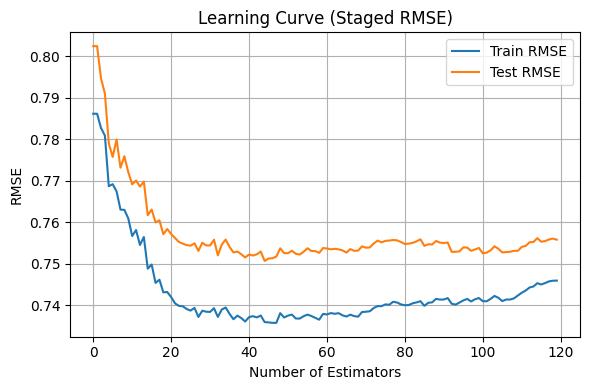

In [58]:
model = pipe.named_steps["model"]
train_rmse, test_rmse = [], []
for p in model.staged_predict(X_train):
    train_rmse.append(RMSE(y_train, p))
for p in model.staged_predict(X_test):
    test_rmse.append(RMSE(y_test, p))

plt.figure(figsize=(6,4))
plt.plot(train_rmse, label="Train RMSE")
plt.plot(test_rmse,  label="Test RMSE")
plt.xlabel("Number of Estimators"); plt.ylabel("RMSE"); plt.title("Learning Curve (Staged RMSE)")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.savefig(ARTIFACTS_DIR / "learning_curve.png"); plt.show()

## Residuals

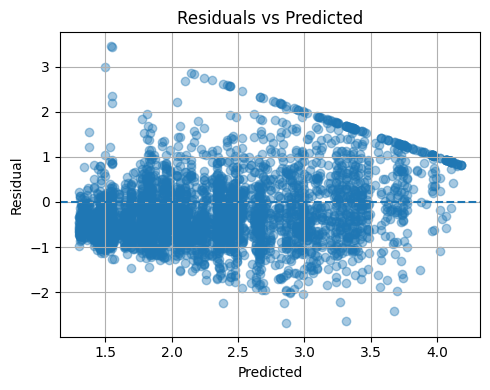

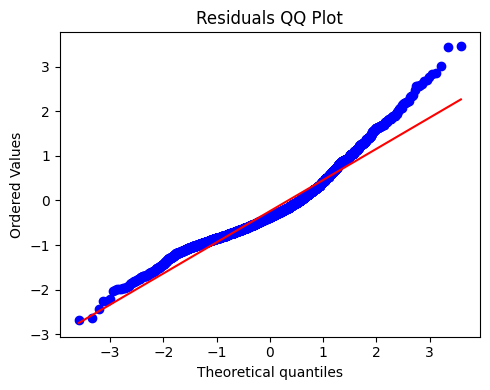

In [59]:
resid = y_test - y_pred

plt.figure(figsize=(5,4))
plt.scatter(y_pred, resid, alpha=0.4)
plt.axhline(0.0, ls="--")
plt.xlabel("Predicted"); plt.ylabel("Residual"); plt.title("Residuals vs Predicted")
plt.grid(True); plt.tight_layout()
plt.savefig(ARTIFACTS_DIR / "residuals_vs_pred.png"); plt.show()

plt.figure(figsize=(5,4))
st.probplot(resid, dist="norm", plot=plt)
plt.title("Residuals QQ Plot"); plt.tight_layout()
plt.savefig(ARTIFACTS_DIR / "residuals_qq.png")
plt.show()

# 9) Explainability: Permutation Importance + PDPs

,feature,importance_mean,importance_std
0,MedInc,0.717241,0.015035
1,AveOccup,0.143845,0.003851
2,Latitude,0.080796,0.003050
3,Longitude,0.028140,0.000927
4,HouseAge,0.014346,0.001451
5,AveRooms,0.005879,0.001209
6,Population,0.001266,0.000320
7,AveBedrms,-0.000089,0.000050


<Figure size 600x400 with 0 Axes>

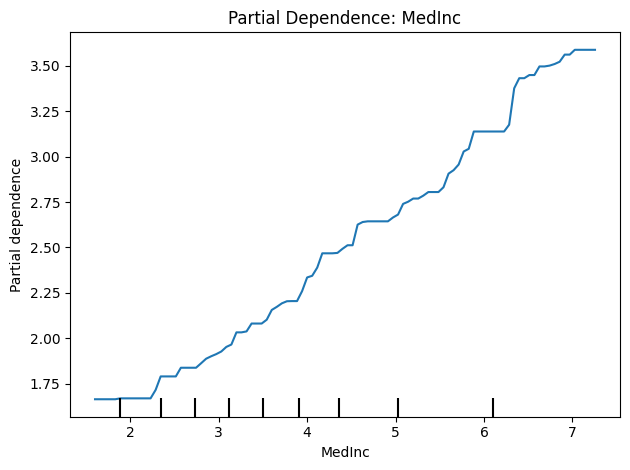

<Figure size 600x400 with 0 Axes>

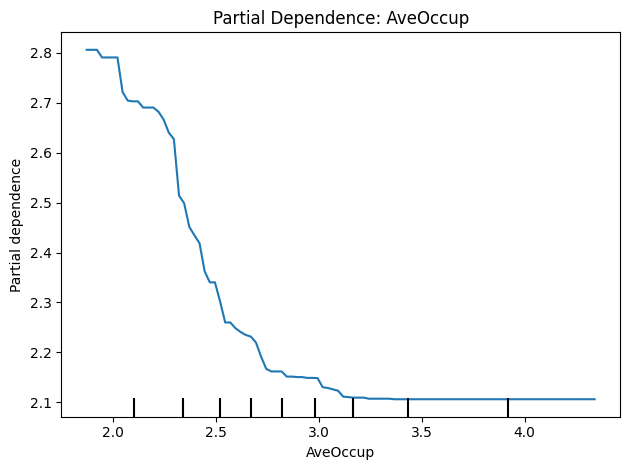

In [60]:
# What & Why:
# - Permutation importance is more trustworthy than impurity importance for trees.
# - PDPs show average effect of a feature on predictions (top 2 features).

perm = permutation_importance(pipe, X_test, y_test, n_repeats=5, random_state=RANDOM_STATE, n_jobs=-1)
fi = (pd.DataFrame({"feature": columns,
                    "importance_mean": perm.importances_mean,
                    "importance_std":  perm.importances_std})
        .sort_values("importance_mean", ascending=False)
        .reset_index(drop=True))
display(fi.head(10))
fi.to_csv(ARTIFACTS_DIR / "feature_importance.csv", index=False)

top_feats = fi["feature"].head(2).tolist()
for feat in top_feats:
    try:
        fig = plt.figure(figsize=(6,4))
        PartialDependenceDisplay.from_estimator(pipe, X_test, [feat])
        plt.title(f"Partial Dependence: {feat}")
        plt.tight_layout()
        plt.savefig(ARTIFACTS_DIR / f"pdp_{feat}.png")
        plt.show()
    except Exception:
        pass

# 10) Save Pipeline + Schema (for Reproducible Inference)

In [61]:
# What & Why:
# - Save the WHOLE pipeline (not just the model) to avoid preprocessing mismatch.
# - Save schema (column order, target, data source) to prevent feature misalignment later.

joblib.dump(pipe, ARTIFACTS_DIR / "adaboost_pipeline.joblib")
with open(ARTIFACTS_DIR / "schema.json", "w") as f:
    json.dump({
        "columns": columns,
        "target": target_name,
        "data_source": data_source,
        "note": "Features are numeric. No scaling is needed for tree base learners."
    }, f, indent=2)

print("Saved: adaboost_pipeline.joblib, schema.json")

Saved: adaboost_pipeline.joblib, schema.json


# 11) Inference Demo: Load & Predict

In [62]:
# What & Why:
# - Example of how to use the saved pipeline later (e.g., in an API).
# - Uses a few rows from X_test to show round-trip consistency.

loaded = joblib.load(ARTIFACTS_DIR / "adaboost_pipeline.joblib")
sample = X_test.head(5)
preds = loaded.predict(sample)

print("Sample predictions (first 5 rows of X_test):")
display(pd.DataFrame({"prediction": preds}, index=sample.index))

Sample predictions (first 5 rows of X_test):


,prediction
20046,1.499626
3024,1.540189
15663,3.117452
20484,2.618141
9814,2.361305
